In [5]:
# Importamos librerias y definimos funciones de operaciones de curvas elípticas

import hashlib
import random
import binascii

def extended_gcd(a, b):
    x0, x1, y0, y1 = 1, 0, 0, 1
    while b != 0:
        q, a, b = a // b, b, a % b
        x0, x1 = x1, x0 - q * x1
        y0, y1 = y1, y0 - q * y1
    return a, x0, y0


def calc_inv(a, Zn):
    gcd, x, y = extended_gcd(a, Zn)
    if gcd != 1:
        return False
    return x % Zn


def inv_aditivo(x, p):
    if x <= p - 1:
        return p - x
    if x > p:
        return p - (x % p)


def exp_binaria(x, n):
    resultado = 1
    q = n - 2
    while q > 0:
        if q % 2 == 1:
            resultado = (resultado * x) % n
        x = (x * x) % n
        q = q // 2
    return resultado


def pendiente(x1, y1, x2, y2, a, p):
    if (x1 and y1) is None or (x2, y2) is None:
        return (x1, y1) or (x2, y2)
    if (x1 == x2 and y1 == y2):
        return (((3 * x1 * x1) + a) * exp_binaria(2 * y1, p)) % p
    else:
        return ((y2 + inv_aditivo(y1, p)) * exp_binaria(x2 + inv_aditivo(x1, p), p)) % p


def suma_de_la_curva(x1, y1, x2, y2, s, p):
    x3 = 0
    y3 = 0

    x3 = (s * s + inv_aditivo(x1, p) + inv_aditivo(x2, p)) % p
    y3 = (s * (x1 + inv_aditivo(x3, p)) + inv_aditivo(y1, p)) % p
    return x3, y3


def mult_binaria(x, y, a, p, n):
    n = bin(n)[3:]
    x2 = x
    y2 = y
    for i in n:
        if i == '1':
            s = pendiente(x2, y2, x2, y2, a, p)
            x2, y2 = suma_de_la_curva(x2, y2, x2, y2, s, p)
            s = pendiente(x2, y2, x, y, a, p)
            x2, y2 = suma_de_la_curva(x, y, x2, y2, s, p)

        if i == '0':
            s = pendiente(x2, y2, x2, y2, a, p)
            x2, y2 = suma_de_la_curva(x2, y2, x2, y2, s, p)

    return x2, y2



def sign_message(message, private_key):
    # Definiendo curva NIST P-256
    p = int(0xffffffff00000001000000000000000000000000ffffffffffffffffffffffff)
    a = int(0xffffffff00000001000000000000000000000000fffffffffffffffffffffffc)
    b = int(0x5ac635d8aa3a93e7b3ebbd55769886bc651d06b0cc53b0f63bce3c3e27d2604b)
    gx = int(0x6b17d1f2e12c4247f8bce6e563a440f277037d812deb33a0f4a13945d898c296)
    gy = int(0x4fe342e2fe1a7f9b8ee7eb4a7c0f9e162bce33576b315ececbb6406837bf51f5)
    n = int(0xffffffff00000000ffffffffffffffffbce6faada7179e84f3b9cac2fc632551)
    x = private_key
    # = 1

    # k = random.randint(1, n - 1)
    k = int(0xA6E3C57DD01ABE90086538398355DD4C3B17AA873382B0F24D6129493D8AAD60)
    x1, y1 = mult_binaria(gx, gy, a, p, k)
    r = x1 % n

    # Se regresa al paso 1 en caso de que r==0
    if r == 0:
        return sign_message(message, private_key)

    # Generando k inversa
    k_inv = exp_binaria(k, n)
    # k_inv = pow(k,-1,n)
    # Convirtiendo mensaje hasheado a entero
    hash_object = hashlib.sha256()
    hash_object.update(message.encode())
    hexa = binascii.hexlify(hash_object.digest())
    e = int(hexa,16)
    s = (k_inv * (e + x * r)) % n

    # Se regresa al paso 1 en caso de que s==0
    if s == 0:
        return sign_message(message, private_key)
    return (r, s)

In [6]:
# Se implementa el algoritmo de verificación, los pasos seguidos para montar este algoritmo se encuentran en la descripción de la función.
def verify_ecdsa_signature(r, s, m, n, G, Q, a):
    '''
    Algoritmo de verificación obtenido de (Johnson D., Menezes A., Vanstone S., 2001)
    https://link.springer.com/content/pdf/10.1007/s102070100002.pdf?pdf=button 
    '''
    # Paso 1: Verify que r y s esten en el intervalo [1, n-1]
    if  not(1 <= r < n and 1 <= s < n):
        return 'Step 1 Failed'

    # Paso 2: Hashear mensaje con SHA-256 y convertirlo a decimal
    hash_object = hashlib.sha256()
    hash_object.update(m.encode())
    hexa = binascii.hexlify(hash_object.digest())
    e = int(hexa,16)
    
    # Paso 3: Computar w = s^-1 mod n
    w = calc_inv(s, n)

    # Paso 4: Computar u1 = (e * w) mod n and u2 = (r * w) mod n
    u1 = (e * w) % n
    u2 = (r * w) % n

    # Paso 5: Computar X = u1G + u2Q
    x1, y1 = mult_binaria(G[0],G[1],a,p,u1)
    x2, y2 = mult_binaria(Q[0],Q[1],a,p,u2)
    pend = pendiente(x1,y1,x2,y2,a,p)
    x3, y3 = suma_de_la_curva(x1,y1,x2,y2,pend,p)

    # Paso 6: If X == O, rechazar la firma
    if (x3, y3) == (0, 0):
        return 'Rechazar firma'

    # Paso 7: Computar v = x3 mod n
    v = x3 % n
    # Step 8: Aceptar la firma si y solo si v = r
    return v==r

In [7]:
# Definimos los parámetros de la curva, y la llave privada.
p = int(0xffffffff00000001000000000000000000000000ffffffffffffffffffffffff)
a = int(0xffffffff00000001000000000000000000000000fffffffffffffffffffffffc)
b = int(0x5ac635d8aa3a93e7b3ebbd55769886bc651d06b0cc53b0f63bce3c3e27d2604b)
gx = int(0x6b17d1f2e12c4247f8bce6e563a440f277037d812deb33a0f4a13945d898c296)
gy = int(0x4fe342e2fe1a7f9b8ee7eb4a7c0f9e162bce33576b315ececbb6406837bf51f5)
n = int(0xffffffff00000000ffffffffffffffffbce6faada7179e84f3b9cac2fc632551)

# Definimos la clave privada x(pseudo-aleatoria) de esta forma, como en el RFC-6979
x = int(0xC9AFA9D845BA75166B5C215767B1D6934E50C3DB36E89B127B8A622B120F6721)
Ux,Uy = mult_binaria(gx,gy,a,p,x)

print('Ux: ', hex(Ux))
print('Uy: ', hex(Uy))

Ux:  0x60fed4ba255a9d31c961eb74c6356d68c049b8923b61fa6ce669622e60f29fb6
Uy:  0x7903fe1008b8bc99a41ae9e95628bc64f2f1b20c2d7e9f5177a3c294d4462299


(Ux, Uy) representan a la clave pública, podemos observar que es la misma llave pública que se obtiene en el rfc-6979.
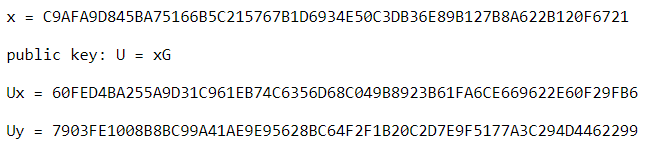

Esto indica que la operación escalar por punto de curva se está efectuando de forma correcta.

In [8]:
# Firmado de mensaje
r,s = sign_message("sample", x)

print('r: ', hex(r))
print('s: ', hex(s))

r:  0xefd48b2aacb6a8fd1140dd9cd45e81d69d2c877b56aaf991c34d0ea84eaf3716
s:  0xf7cb1c942d657c41d436c7a1b6e29f65f3e900dbb9aff4064dc4ab2f843acda8


Podemos observar como r y s son identicas a las que deberian ser obtenidas según el RFC-6979.
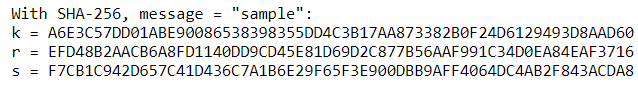

Cabe recordar que k en este caso se selecciono de forma no aleatoria, sino que se uso el mismo valor que el que se presenta en la imagen, esto debido a que se busca imitar los resultados obtenidos por el RFC-6979 para ECDSA con SHA-256 en la curva NIST P-256, por lo que los parámetros pseudo-aleatorios tendrán que tomar un valor específico para comprobar el funcionamiento correcto del ECDSA.

In [9]:
# Verificación de firma
verify_ecdsa_signature(r,s,"sample",n,(gx, gy),(Ux, Uy), a)

True

La función nos arroja True, en este caso significa que las variables del algoritmo de verificación r y v, son iguales, lo cual verifica la firma.